# Skill & Importance level data importation

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
from numpy import asarray

# Got a little help from this website:
# https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe

# Specify the directory of all of our Skill csv's
directory = 'data/'

# Create a list to put all of our dataframes in
li = []

# Loop through every image in the directory
for filename in os.listdir(directory):
    # Skip the .DS_Store in the directory:
    if '.csv' in filename:
        # Create a dataframe file
        df = pd.read_csv(directory + filename, header = 0)
        # Attribute the name of the skill to a particular column so that we can concatenate later
        # Split up to -4, so that we don't include the '.csv' at the end of the filename
        df['Skill'] = filename[:-4]
        li.append(df)

# Concatenate the dataframes by column
frame = pd.concat(li, axis = 0, ignore_index = True)

# Convert column 'Importance' of the dataframe to dtype of int
# We cannot use 'Level', because one particular entry of 'Level' is equal to not-available,
# but all entries of 'Importance' is available
frame["Importance"] = pd.to_numeric(frame["Importance"])

# Check the heading rows of the dataframe
frame.head()

,Importance,Level,Code,Occupation,Skill
0,97,80,21-1014.00,Mental Health Counselors,Social_Perceptiveness
1,94,76,19-3033.00,Clinical and Counseling Psychologists,Social_Perceptiveness
2,88,77,29-1223.00,Psychiatrists,Social_Perceptiveness
3,85,82,21-1013.00,Marriage and Family Therapists,Social_Perceptiveness
4,81,77,21-2011.00,Clergy,Social_Perceptiveness


# Webcrawling to get job income data

In [2]:
# Tutorial from this website:
# https://www.thepythoncode.com/article/extract-all-website-links-python
import requests
from urllib.parse import urlparse, urljoin
from bs4 import BeautifulSoup
import colorama


# We are going to use colorama just for using different colors when printing,
# to distinguish between internal and external links:
# init the colorama module
colorama.init()
GREEN = colorama.Fore.GREEN
GRAY = colorama.Fore.LIGHTBLACK_EX
RESET = colorama.Fore.RESET
YELLOW = colorama.Fore.YELLOW


# We gonna need two global variables, one for all internal links of the website
# and the other for all the external links:
# initialize the set of links (unique links)
internal_urls = set()
external_urls = set()


# Since not all links in anchor tags (a tags) are valid (I've experimented with this),
# some are links to parts of the website, some are javascript, so let's write a function to validate URLs:
def is_valid(url):
    """
    Checks whether `url` is a valid URL.
    """
    parsed = urlparse(url)
    return bool(parsed.netloc) and bool(parsed.scheme)


# Now let's build a function to return all the valid URLs of a web page:
def get_all_website_links(url):
    """
    Returns all URLs that is found on `url` in which it belongs to the same website
    """
    # all URLs of `url`
    # initialized the urls set variable
    urls = set()
    
    # domain name of the URL without the protocol
    # extracted the domain name from the URL, we gonna need it to check
    # whether the link we grabbed is external or internal.
    domain_name = urlparse(url).netloc
    
    # downloaded the HTML content of the web page and wrapped it with a soup object to ease HTML parsing.
    soup = BeautifulSoup(requests.get(url).content, "html.parser")
    
    # Let's get all HTML a tags (anchor tags that contains all the links of the web page)
    for a_tag in soup.findAll("a"):
        # get the href attribute and check if there is something there. Otherwise, we just continue to the next link.
        href = a_tag.attrs.get("href")
        if href == "" or href is None:
            # href empty tag
            continue
    
    # not all links are absolute, we gonna need to join relative URLs with their domain name
    # (e.g when href is "/search" and url is "google.com", the result will be "google.com/search"):
        # join the URL if it's relative (not absolute link)
        href = urljoin(url, href)
    
        # Now we need to remove HTTP GET parameters from the URLs,
        # since this will cause redundancy in the set, the below code handles that:
        parsed_href = urlparse(href)
        # remove URL GET parameters, URL fragments, etc.
        href = parsed_href.scheme + "://" + parsed_href.netloc + parsed_href.path
        
        # Finish up
        if not is_valid(href):
            # not a valid URL
            continue
        if href in internal_urls:
            # already in the set
            continue
        if domain_name not in href:
            # external link
            if href not in external_urls:
                # not already in the set
                # Excluded this line to prevent a huge amount of print statements
                # print(f"{GRAY}[!] External link: {href}{RESET}")
                external_urls.add(href)
            continue
        # Valid, not already in the set, and not an external link:
        # Excluded this line to prevent a huge amount of print statements
        # print(f"{GREEN}[*] Internal link: {href}{RESET}")
        urls.add(href)
        internal_urls.add(href)
    return urls


# The above function will only grab the links of one specific page,
# what if we want to extract all links of the entire website? Let's do this:
# number of urls visited so far will be stored here
total_urls_visited = 0

def crawl(url, max_urls=30):
    """
    Crawls a web page and extracts all links.
    You'll find all links in `external_urls` and `internal_urls` global set variables.
    params:
        max_urls (int): number of max urls to crawl, default is 30.
    """
    global total_urls_visited
    total_urls_visited += 1
    print(f"{YELLOW}[*] Crawling: {url}{RESET}")
    links = get_all_website_links(url)
    for link in links:
        if total_urls_visited > max_urls:
            break
        crawl(link, max_urls=max_urls)

# First get all of the url hyperlinks so that I can strap each of their earnings data
# There are several search engines on the website, so I will scrape one by one, and combine unique items

# By bright outlook - https://www.onetonline.org/find/bright?b=0&g=Go
all_urls_bright_outlook = get_all_website_links("https://www.onetonline.org/find/bright?b=0&g=Go")

# By career cluster - https://www.onetonline.org/find/career?c=0&g=Go
all_urls_by_cluster = get_all_website_links("https://www.onetonline.org/find/career?c=0&g=Go")

# By Industry - https://www.onetonline.org/find/industry?i=0&g=Go
all_urls_by_industry = get_all_website_links("https://www.onetonline.org/find/industry?i=0&g=Go")

# By Job Family - https://www.onetonline.org/find/family?f=0&g=Go
all_urls_by_family = get_all_website_links("https://www.onetonline.org/find/family?f=0&g=Go")

# By Job Zone - https://www.onetonline.org/find/zone?z=0&g=Go
all_urls_by_zone = get_all_website_links("https://www.onetonline.org/find/zone?z=0&g=Go")

# By STEM - https://www.onetonline.org/find/stem?t=0
all_urls_by_stem = get_all_website_links("https://www.onetonline.org/find/stem?t=0")

# Create a list that contains all of them
all_url_list = [all_urls_bright_outlook, all_urls_by_cluster, all_urls_by_industry,
                all_urls_by_family, all_urls_by_zone, all_urls_by_stem]

# Create a new empty list
all_urls = []

# Loop over the list to throw away repeated urls
for url_list in all_url_list:
    all_urls = all_urls + list(set(url_list) - set(all_urls))

In [3]:
# From my understanding of the website, all jobs are stored in links with a particular code at the end of the link
# Checking the urls, this means that it is "link/summary/..."
# We are going to scrape all of these websites' job name, and job earning data

# Tutorial from this website:
# https://www.edureka.co/blog/web-scraping-with-python/
# and this website:
# https://towardsdatascience.com/web-scraping-basics-82f8b5acd45c
from selenium import webdriver

job_names = [] # List to store name of the jobs
earnings = [] # List to store earnings of the jobs

def get_name_and_earning(url):
    # Get the entire html sequence, format with BeautifulSoup
    req = requests.get(url)
    content = req.text
    soup = BeautifulSoup(content)
    
    # Some of these links are summary of military occupations and thus does not contain any wage information,
    # we need to exclude these links from our crawl
    if soup.find('div', attrs = {'id':'wrapper_WagesEmployment'}) != None:
        
        # Find the value using these attributes
        # titleb is unique thus we can directly use find
        name = soup.find('span', attrs = {'class':'titleb'})
        
        # report2 is not unique, thus we need to isolate the section where it's in first
        wages_employment = soup.find('div', attrs = {'id':'wrapper_WagesEmployment'})
        # Then we can find the wages data that's stored in this section
        earning = wages_employment.find('td', attrs = {'class':'report2'})
    
        # Append them to our lists
        job_names.append(name.text)
        earnings.append(earning.text)

# Crawl Job name and Job earnings data from all of our urls, given that it is the summary page of a job
for link in all_urls:
    if "/link/summary/" in link:
        get_name_and_earning(link)

In [4]:
# Tailor the earnings list so that it is properly formatted
for i in range(len(earnings)):
    
    # Find the index of the last dollar sign
    dollar_sign = earnings[i].rfind('$')
    
    # If the job does have an annual earnings value
    if 'annual' in earnings[i]:
        
        # Find the index of the first letter 'a' for 'annual'
        annual = earnings[i].find('a')
        
        # We want to get a pure intger string, thus we exlude the dollar sign by +1,
        # and exclude the space before the 'annual' by -1
        # i.e. normally the annual wage would be in this: earnings[i][dollar_sign+1:annual-1]
        
        # If the plus sign is in the annual wage (meaning that the wage is $208,000+)
        if '+' in earnings[i][dollar_sign+1:annual-1]:
            # Further exclude this '+' sign by using -2 in the latter split
            # Dropping the ',' in the string by using the replace function
            # Then turn it into an integer and assign to its original position
            earnings[i] = int(earnings[i][dollar_sign+1:annual-2].replace(',', ''))
        
        # Else plus sign isn't in the annual wage, then we just continue as normal
        else:
            # Dropping the ',' in the string by using the replace function
            # Then turn it into an integer and assign to its original position
            earnings[i] = int(earnings[i][dollar_sign+1:annual-1].replace(',', ''))
    
    # If the job does not have an annual earnings value
    else:
        # Find the index of the first letter 'h' for 'hourly'
        hourly = earnings[i].find('h')
        
        # Approximate the annual wage by multiplying the hourly wage by 8 hours a day,
        # 5 days a week, and 52 weeks a year
        # Dropping the ',' in the string by using the replace function
        # Then turn this into a float
        # Then multiply by *8*5*52 to approximate for annual wage
        # Finally round to 1 decimal place, and assign to its original position
        earnings[i] = round(float(earnings[i][dollar_sign+1:hourly-1].replace(',', ''))*8*5*52, 1)

# Check that we properly formatted everything
# earnings

In [5]:
# Tailor the job_names list so that it is properly formatted
for i in range(len(job_names)):
    
    # Find the index of the first occurance of '-' sign, this is the '-' in the code of the job
    index1 = job_names[i].find('-')
    
    # Find the index of the second occurance of '-' sign, everything after this sign is the actual job name
    index2 = job_names[i][index1+1:].find('-')
    
    # Combine these two index values to get the actual index value in the original entry
    index = index1 + index2 
    
    # Index+3 to take out the '-' sign and the space, and assign to its original position
    job_names[i] = job_names[i][index+3:]

In [6]:
# Put into a dataframe, enforce the second column to become integers
job_earnings_data = pd.DataFrame({'Job Name':job_names, 'Annual Earnings':earnings}, dtype = np.int8) 

/var/folders/sr/pgt_1qtd02s8mtf331by6sm80000gn/T/ipykernel_3699/59072683.py:2: FutureWarning: Could not cast to int8, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  job_earnings_data = pd.DataFrame({'Job Name':job_names, 'Annual Earnings':earnings}, dtype = np.int8)


# Combining data sets, and a simple linear model

In [7]:
# Create a duplicate dataframe that contains the sum of the importance column's values,
# summed for the occupation that it belongs to
dff = frame.groupby(["Occupation"]).Importance.sum().reset_index()
dff.head()

,Occupation,Importance
0,Actuaries,465
1,Acute Care Nurses,225
2,Adhesive Bonding Machine Operators and Tenders,72
3,"Administrative Law Judges, Adjudicators, and H...",399
4,Administrative Services Managers,75


In [8]:
# Standardize the importance column, this will be done by dividing each importance value,
# by the sum of importance value for the job it is attributed to (from the previous block)
importance_standardized = []

for row in frame.iloc():
    # For every row, calculate the standardized importance values and append to list
    importance_standardized.append(row.Importance / dff.Importance[dff['Occupation'] == row.Occupation])

# Extract the values from the pandas series object
for i in range(len(importance_standardized)):
    importance_standardized[i] = importance_standardized[i].item()

# Assign this column into the dataframe as a new column
frame['Standardized Importance (by Occupation)'] = importance_standardized

In [14]:
# Assign an empty list to obtain earnings value of each skill (by job),
# by multiplying earning by standardized importance
earning_by_skill = []

for row in frame.iloc():
    # For every row, multiply the skill's standardized importance by the earnings of the job the skill attributes to
    earning_by_skill.append(row['Standardized Importance (by Occupation)'] * job_earnings_data.loc[job_earnings_data['Job Name'] == row.Occupation, 'Annual Earnings'].item())

# Assign this column into the dataframe as a new column
frame['Earning by Importance of Skill in Job'] = earning_by_skill

/var/folders/sr/pgt_1qtd02s8mtf331by6sm80000gn/T/ipykernel_3699/1909888738.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bar_plot_df[column_name][row_number] = row["Earning by Importance of Skill in Job"]


<AxesSubplot:title={'center':'Earning of each job by skill'}, xlabel='Occupation'>

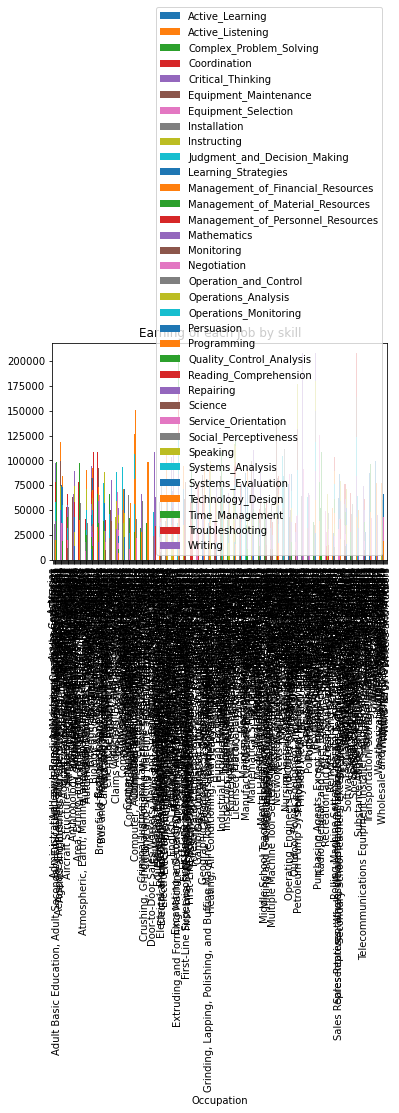

In [46]:
# Create a stacked bar plot for earning of jobs, by skill
import matplotlib.pyplot as plt

# Gather all of the unique skill names
skills = frame['Skill'].values
unique_skills = list(np.unique(skills))

# Gather all of the unique occupations
occupations = frame['Occupation'].values
unique_occupations = list(np.unique(occupations))

# Create an empty dataframe, with these unique skills as column headers
bar_plot_df = pd.DataFrame(np.zeros((len(unique_occupations), len(unique_skills))), columns = unique_skills)

# Insert the occupations into this dataframe as a new column
bar_plot_df['Occupation'] = unique_occupations

# Populate this dataframe by adding data from our frame dataframe, looping over the entirety of it
for row in frame.iloc():
    # Specify the column name
    column_name = row.Skill
    
    # Find the row number
    for i in range(len(bar_plot_df["Occupation"])):
        if bar_plot_df["Occupation"][i] == row.Occupation:
            row_number = i
            break
    else:
        # Impossible tbh, because it uses unique values from the original list
        raise ValueError("Occupation Specified not in original dataframe!")
    
    # Populate the column_name and row_number of our bar_plot_df with values from the original frame
    bar_plot_df[column_name][row_number] = row["Earning by Importance of Skill in Job"]

# Plot data in stack manner of bar type
bar_plot_df.plot(x = 'Occupation', kind = 'bar', xlabel = 'Occupations', ylabel = 'Annual Earnings',
                 stacked = True, title = 'Earning of each job by skill')

In [52]:
# Find the skills with the greatest earning
columns = frame['Earning by Importance of Skill in Job']
max_earning = columns.max()

for row in frame.iloc():
    if row['Earning by Importance of Skill in Job'] == max_earning:
        print(f"The skill of {row.Skill} relative to the job of {row.Occupation} grants you {max_earning} of annual income.")

The skill of Writing relative to the job of Radiologists grants you 208000.0 of annual income.
The skill of Critical_Thinking relative to the job of Physical Medicine and Rehabilitation Physicians grants you 208000.0 of annual income.
The skill of Service_Orientation relative to the job of Dermatologists grants you 208000.0 of annual income.
The skill of Operations_Analysis relative to the job of Orthodontists grants you 208000.0 of annual income.


In [59]:
# Find the average earning of each skill, averaged out over all of the occupations that the skill attributes to
mean_earnings_of_skill_over_job = bar_plot_df.mean()

# Show the average earnings of each job, ordered from the largest to the smallest
mean_earnings_of_skill_over_job.sort_values(ascending = False)

/var/folders/sr/pgt_1qtd02s8mtf331by6sm80000gn/T/ipykernel_3699/1294051941.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_earnings_of_skill_over_job = bar_plot_df.mean()


Programming                          3736.136594
Operations_Analysis                  3498.729638
Science                              3318.744496
Critical_Thinking                    2939.488539
Writing                              2926.480486
Operation_and_Control                2877.008405
Technology_Design                    2865.983765
Mathematics                          2779.405052
Service_Orientation                  2741.020483
Operations_Monitoring                2673.080744
Time_Management                      2600.628954
Management_of_Financial_Resources    2576.586817
Instructing                          2430.116910
Management_of_Personnel_Resources    2374.100800
Monitoring                           2372.646283
Complex_Problem_Solving              2279.883673
Judgment_and_Decision_Making         2248.705696
Quality_Control_Analysis             2200.281377
Social_Perceptiveness                2181.644985
Systems_Evaluation                   2180.726678
Systems_Analysis    

This initial analysis made very much sense to me. Although it is a very simplistic model that normalizes the importance of each skill by the occupation that it is attributed to, and arbitrarily averages the earning of each skill over the occupations, it still seems to offer much value here.

We can see that the skill of programming offers the highest earning, which is relatively within our expectations with the high-speed digitalization of the world around us. Everything is starting to jump free from manual labor and getting taken over by algorithms and machinery, which is why programming would be such a valuable skill.

The next-in-line is Operations analysis, which is "Analyzing needs and product requirements to create a design." Sounds a lot like what Product Managers do. Combined with Software Engineers which mostly applies the former skill "programming", these two jobs are the highest paying entry-to-middle level jobs in any modern day tech company. So it still makes a lot of sense to me, although executive skills (which we would expect to have the highest earning since executive roles earn the highest earnings) did not appear to be high on the list.

I think there is a lot of richness in this dataset, and there is definitely possibility for richer analysis from this point. I will continue to explore machine learning methods that can be applied to this dataset in the future (very likely Bayesian methods to include some confidence interval/probability), to try to build a more robust model, and build my economics analysis surrounding it.